In [1]:
import matplotlib.pyplot as plt
# for inline plots in jupyter
%matplotlib inline
import numpy as np
import math

In [2]:
# import seaborn
import seaborn as sns
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(5,5)})

In [3]:
from scipy.stats import beta
infest_beta = beta.rvs(4, 60, size=10000)

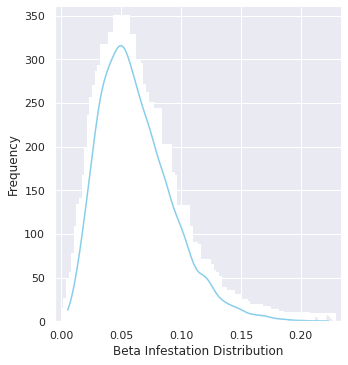

In [4]:
ax = sns.displot(infest_beta,
                 kde=True,
                 bins=100,
                 color='skyblue',
                 linewidth=15,
                 alpha=1)
ax.set(xlabel='Beta Infestation Distribution', ylabel='Frequency')

In [5]:
# Choose infestation rate for shipment from beta distribution
infest_rate = beta.rvs(4, 60, size=1)
print("Infestation rate:", round(infest_rate[0],4))

Infestation rate: 0.0301


In [6]:
num_stem = np.random.randint(1, high=1000000, size=1) #QUANTITY

# Calculate number of pests in shipment based on infestation rate.
num_pest = int(num_stem * infest_rate)
print("Num stems: ", int(num_stem))
print("Num pests:", num_pest)
np.arange(num_stem)

Num stems:  152656
Num pests: 4590


array([     0,      1,      2, ..., 152653, 152654, 152655])

In [7]:
# Infest stems using uniform distribution
infest_stem_unif = np.random.choice(int(num_stem), num_pest, replace = False)

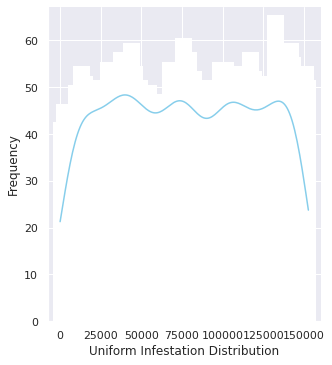

In [8]:
ax = sns.displot(infest_stem_unif,
                 kde=True,
                 bins=100,
                 color='skyblue',
                 linewidth=15,
                 alpha=1)
ax.set(xlabel='Uniform Infestation Distribution', ylabel='Frequency')

In [9]:
from scipy.stats import gamma

# Infest stems using gamma distribution to create cluster of pests.
infest_clust = gamma.rvs(3, scale=500, size=40000) #rvs(a, loc=0, scale=1, size=1, random_state=None)
infest_clust = [round(x) for x in infest_clust]

# Insert infested cluster of stems into shipment at random position
start_clust = np.random.randint(1, high = num_stem - max(infest_clust), size = 1)
infest_stem_clust = infest_clust + start_clust

print("Size of cluster:", int(max(infest_stem_clust) - min(infest_stem_clust)), "stems")

Size of cluster: 7842 stems


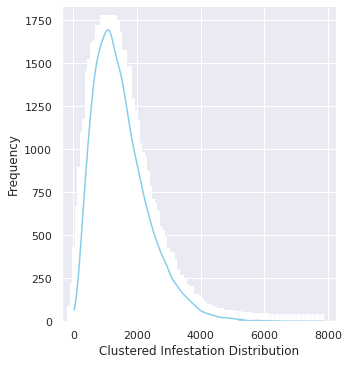

In [10]:
ax = sns.displot(infest_clust,
                 kde=True,
                 bins=100,
                 color='skyblue',
                 linewidth=15,
                 alpha=1)
ax.set(xlabel='Clustered Infestation Distribution', ylabel='Frequency')

In [11]:
num_boxes = math.ceil(num_stem / 200)
print(num_boxes)

764
